<a href="https://colab.research.google.com/github/IreneScarpanti/Tesi/blob/main/Irene_project_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importa le librerie necessarie

```
# This is formatted as code
```



In [1]:
# importa le librerie necessarie ed altre funzioni predefinite preliminari
!pip install adversarial-robustness-toolbox
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
import random

print(tf.executing_eagerly())
# Disabilita l'esecuzione immediata (questa riga deve essere eseguita prima di qualsiasi altra operazione TensorFlow)
#tf.compat.v1.disable_eager_execution()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.1 MB/s eta 0:00:00
True


# Preparazione e preprocessing del dataset MNIST

In [2]:
# istruzione: importa MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# istruzione: normalizza MNIST
x_train, x_test = x_train / 255.0, x_test / 255.0
# istruzione: dividi in train / val / test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# reshape adatto per una rete convoluzionale
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training di un classificatore MNIST


In [3]:
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 161ms/step - accuracy: 0.8316 - loss: 0.5967 - val_accuracy: 0.9753 - val_loss: 0.0798
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 112ms/step - accuracy: 0.9789 - loss: 0.0680 - val_accuracy: 0.9831 - val_loss: 0.0516
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9870 - loss: 0.0427 - val_accuracy: 0.9857 - val_loss: 0.0480
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.9899 - loss: 0.0311 - val_accuracy: 0.9865 - val_loss: 0.0443
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.9923 - loss: 0.0245 - val_accuracy: 0.9878 - val_loss: 0.0389
Test accuracy: 0.9906


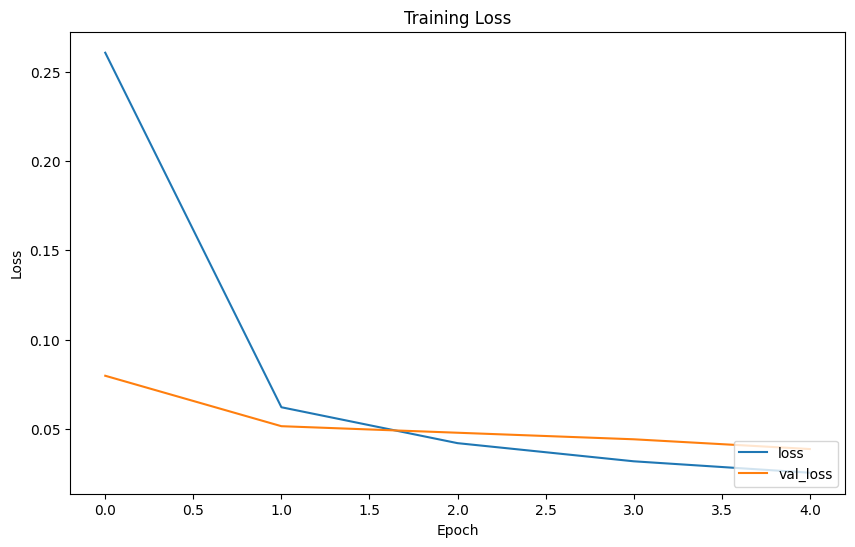

In [4]:
# model fitting
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val), verbose=1)

# Evaluate the model on test data and plot training loss
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='higher right')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


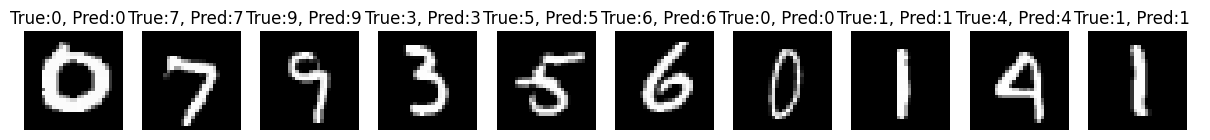

In [22]:
# Visualizzazione delle predizioni

# Funzione per visualizzare alcune immagini di esempio
def plot_examples(x, y_true, y_pred, n=10):
    # istruzione: riempi questa funzione in modo da costruire un grafico di n pannelli,
    # in cui in ogni pannello viene visualizzata un'immagine random del test set,
    # e nel titolo (o come label) vengano scritti anche i valori predetti ed i valori reali (aspettati)
    # questa funzione verrà richiamata anche più in la nel codice
      plt.figure(figsize=(15, 15))
      for i in range(n):
          idx = random.randint(0, len(x) - 1)  # Manca il -1 per evitare errori di indice
          plt.subplot(1, n, i + 1)
          plt.imshow(x[idx].reshape(28, 28), cmap='gray')
          plt.title(f"True:{np.argmax(y_true[idx])}, Pred:{np.argmax(y_pred[idx])}  ")
          plt.axis('off')
      #plt.subplots_adjust(wspace=0.5)
      plt.show()
y_pred = model.predict(x_test)

plot_examples(x_test, y_test, y_pred)


# Implementazione di attacchi avversari tramite Adversarial robustness toolbox (ART)

In [ ]:
# Creare il classificatore ART
art_classifier = KerasClassifier(model=model, clip_values=(0, 1))
# clip_values è una tupla di due float che rappresentano i valori minimi e massimi consentiti per le caratteristiche di input.


In [ ]:
# performiamo un attacco FGSM (Fast Gradient Sign Method) con un epsilon = 0.2 e valutiamo l'accuratezza del modello sulle immagini avversarie.
# per creare un attacco FGSM, creare un'istanza della classe FastGradientMethod e chiamare il metodo generate
# eplison è il parametro che controlla la forza dell'attacco, ovvero quanto l'immagine originale può essere modificata.
epsilon = 0.2
fgsm_attack = FastGradientMethod(estimator=art_classifier, eps=epsilon)
x_test_adv = fgsm_attack.generate(x=x_test)

In [ ]:
# valutiamo l'accuratezza del modello sulle immagini avversarie
y_pred_adv = art_classifier.predict(x_test_adv)
adv_accuracy = np.sum(np.argmax(y_pred_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial examples (ε={epsilon}): {adv_accuracy:.4f}")

# mostriamo alcuni esempi di predizioni su immagini avversarie random del test set
# chiamando la funzione plot_examples definita in precedenza
plot_examples(x_test_adv, y_test, y_pred_adv)

# Analisi al variare di epsilon

In [ ]:
# valori di epsilon con cui vogliamo attaccare il dataset e rispetto ai quali vogliamo valutare l'accuratezza del modello
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]


# istruzione: crea un loop in cui generi attacchi ai diversi valori di epsilon, ed ogni volta ti salvi l'accuratezza del modello

# istruzione: fai una figura di accuratezza vs epsilon

# istrizione: fai una figura in cui fai vedere come una stessa qualsiasi immagine random del dataset viene degradata ai diversi valori di epsilon
# per capire fino a che valore di epsilon la degradazione non e' ovviamente notabile.